In [24]:
import pandas as pd
import numpy as np
import plotly.graph_objects as plgo
from plotly.subplots import make_subplots
import seaborn as sns
pd.options.mode.chained_assignment = None

In [2]:
START_DATE = pd.to_datetime('2022-01-03')
END_DATE = pd.to_datetime('2022-02-24')

In [3]:
brent_df = pd.read_csv('oil_futures_2022.csv',
                       usecols=['Date', 'Close'],
                       parse_dates=['Date'],
                       dtype={'Close': float})

brent_df = brent_df[(brent_df['Date'] >= START_DATE) & (brent_df['Date'] <= END_DATE)]
brent_df = brent_df.iloc[::-1].reset_index(drop=True)
brent_df.rename(columns={'Close': 'Value'}, inplace=True)
brent_df.head()

,Date,Value
0,2022-01-03,78.98
1,2022-01-04,80.00
2,2022-01-05,80.80
3,2022-01-06,81.99
4,2022-01-07,81.75


In [4]:
wti_df = pd.read_csv('/Users/shrek/Downloads/Datathon Data/all_commodities.csv',
                     usecols=['Date_Time','Value','Commodity'],
                     parse_dates=['Date_Time'],
                     dtype={'Value': float, 'Commodity': str})

wti_df = wti_df[(wti_df['Commodity']=='West Texas Intermediary Crude Oil') & (wti_df['Date_Time'] >= START_DATE) & (wti_df['Date_Time'] <= END_DATE)]
wti_df = wti_df.iloc[::-1].reset_index(drop=True)
wti_df.drop(columns=['Commodity'], inplace=True)
wti_df.rename(columns={'Date_Time': 'Date'}, inplace=True)
wti_df.head()

,Date,Value
0,2022-01-03,75.99
1,2022-01-04,77.00
2,2022-01-05,77.83
3,2022-01-06,79.47
4,2022-01-07,79.00


In [5]:
henry_df = pd.read_csv('/Users/shrek/Downloads/Datathon Data/all_commodities.csv',
                       usecols=['Date_Time','Value','Commodity'],
                       parse_dates=['Date_Time'],
                       dtype={'Value': float, 'Commodity': str})

henry_df = henry_df[(henry_df['Commodity']=='Henry Hub Natural Gas Spot Price') & (henry_df['Date_Time'] >= START_DATE) & (henry_df['Date_Time'] <= END_DATE)]
henry_df = henry_df.iloc[::-1].reset_index(drop=True)
henry_df.drop(columns=['Commodity'], inplace=True)
henry_df.rename(columns={'Date_Time': 'Date'}, inplace=True)
henry_df.head()

,Date,Value
0,2022-01-03,3.74
1,2022-01-04,3.73
2,2022-01-05,3.78
3,2022-01-06,3.94
4,2022-01-07,3.83


In [11]:
for df in [brent_df, henry_df, wti_df]:
    df['Value'].fillna(method='bfill', inplace=True)
    df['Value_EMA'] = df['Value'].ewm(span=5, adjust=False).mean()

In [14]:
df_probs = pd.read_csv('Russian_Invasion_of_Ukraine_Before_2023.csv',
                       usecols=['forecaster','prediction_start_time','prediction_end_time','prediction'],
                       parse_dates=['prediction_start_time','prediction_end_time'],
                       dtype={'forecaster': 'string', 'prediction': 'float'})

df_probs = df_probs[df_probs['forecaster'] == 'community_prediction'][:-1]
df_probs.drop(columns=['forecaster'], inplace=True)
df_probs['prediction_end_time'] = pd.to_datetime(df_probs['prediction_end_time'])
df_probs.head()

,prediction_start_time,prediction_end_time,prediction
0,2021-12-11 21:03:40.160777+00:00,2021-12-11 21:08:25.951901+00:00,0.580
1,2021-12-11 21:08:25.951901+00:00,2021-12-11 21:10:06.349703+00:00,0.405
2,2021-12-11 21:10:06.349703+00:00,2021-12-11 21:17:15.744079+00:00,0.390
3,2021-12-11 21:17:15.744079+00:00,2021-12-11 21:25:38.876860+00:00,0.390
4,2021-12-11 21:25:38.876860+00:00,2021-12-11 21:27:42.228631+00:00,0.580


In [15]:
df_probs.dtypes

prediction_start_time    datetime64[ns, UTC]
prediction_end_time      datetime64[ns, UTC]
prediction                           float64
dtype: object

In [16]:
df_probs['time_difference'] = df_probs['prediction_end_time'].astype('int64') - df_probs['prediction_start_time'].astype('int64')
df_probs['weighted'] = df_probs['time_difference'] * df_probs['prediction']
df_probs['day'] = df_probs['prediction_start_time'].map(lambda x: x.date)
df_probs_grouped = df_probs.groupby('day').sum(numeric_only=True).reset_index()
df_probs_grouped['prediction'] = df_probs_grouped['weighted'] / df_probs_grouped['time_difference']
df_probs_grouped = df_probs_grouped[['day', 'prediction']]
df_probs_grouped['day'] = pd.to_datetime(df_probs_grouped['day'])
df_probs_grouped = df_probs_grouped[(df_probs_grouped['day'].dt.weekday < 5) & (df_probs_grouped['day'] >= START_DATE) & (df_probs_grouped['day'] <= END_DATE)]
df_probs_grouped['prediction_EMA'] = df_probs_grouped['prediction'].ewm(span=5, adjust=False).mean()
df_probs_grouped.head()

,day,prediction,prediction_EMA
23,2022-01-03,0.323106,0.323106
24,2022-01-04,0.310000,0.318738
25,2022-01-05,0.301518,0.312998
26,2022-01-06,0.288307,0.304768
27,2022-01-07,0.266972,0.292169


In [17]:
fig = plgo.Figure()
fig.add_trace(plgo.Scatter(x=df_probs_grouped['day'], y=df_probs_grouped['prediction'], mode='lines+markers', name='Manifold Prediction %'))
fig.add_trace(plgo.Scatter(x=df_probs_grouped['day'], y=df_probs_grouped['prediction_EMA'], mode='lines+markers', name='Manifold Prediction % EMA'))

fig.update_yaxes(range=[0, 1])
fig.update_layout(title='Manifold Markets Prediction of Russian Invasion of Ukraine Before 2023')
fig.show()

In [18]:
fig = plgo.Figure()
normalize = lambda series: (series - series.min()) / (series.max() - series.min())
for (df,name) in [(brent_df, 'Brent Crude'), (henry_df, 'Henry Hub'), (wti_df, 'WTI')]:
    fig.add_trace(plgo.Scatter(x=df['Date'], y=normalize(df['Value']), mode='lines+markers', name=name))
    fig.add_trace(plgo.Scatter(x=df['Date'], y=normalize(df['Value_EMA']), mode='lines+markers', name=name + ' EMA'))

fig.update_layout(title='Normalized Oil and Natural Gas Prices')
fig.show()

In [19]:
fig = plgo.Figure()
for (df,name) in [(brent_df, 'Brent Crude'), (henry_df, 'Henry Hub'), (wti_df, 'WTI')]:
    fig.add_trace(plgo.Scatter(x=df['Date'], y=normalize(df['Value_EMA']), mode='lines+markers', name=name + ' EMA'))

fig.add_trace(plgo.Scatter(x=df_probs_grouped['day'], y=normalize(df_probs_grouped['prediction_EMA']), mode='lines+markers', name='Manifold Prediction % EMA'))
fig.update_layout(title='Normalized Oil and Natural Gas EMA Prices with Manifold Prediction % EMA')
fig.show()

In [20]:
for (df, name) in [(brent_df, 'Brent Crude'), (wti_df, 'WTI'), (henry_df, 'Henry Hub')]:
    print(f'{name} EMA correlation coefficient with Manifold Prediction % EMA: {np.corrcoef(df["Value_EMA"], df_probs_grouped["prediction_EMA"])[0, 1]}')

Brent Crude EMA correlation coefficient with Manifold Prediction % EMA: 0.8726868219585411
WTI EMA correlation coefficient with Manifold Prediction % EMA: 0.8352588958018002
Henry Hub EMA correlation coefficient with Manifold Prediction % EMA: 0.30839957829715525


Visualizations

In [81]:
brent_df['pctchange'] = brent_df['Value_EMA'].pct_change().dropna()
wti_df['pctchange'] = wti_df['Value_EMA'].pct_change().dropna()
henry_df['pctchange'] = henry_df['Value_EMA'].pct_change().dropna()
df_probs_grouped['pctchange'] = df_probs_grouped['prediction_EMA'].pct_change().dropna()

In [93]:
brent_df['normalized'] = (brent_df['Value_EMA'] - np.mean(brent_df['Value_EMA'])) / np.std(brent_df['Value_EMA'])
wti_df['normalized'] = (wti_df['Value_EMA'] - np.mean(wti_df['Value_EMA'])) / np.std(wti_df['Value_EMA'])
henry_df['normalized'] = (henry_df['Value_EMA'] - np.mean(henry_df['Value_EMA'])) / np.std(henry_df['Value_EMA'])
df_probs_grouped['normalized'] = (df_probs_grouped['prediction_EMA'] - np.mean(df_probs_grouped['prediction_EMA'])) / np.std(df_probs_grouped['prediction_EMA'])

fig = make_subplots(rows=1, cols=4)

fig.add_trace(plgo.Violin(y=brent_df['pctchange'], name='Brent Crude Front Month Future Prices', box_visible=True, meanline_visible=True), row=1, col=1)
fig.add_trace(plgo.Violin(y=wti_df['pctchange'], name='West Texas Intermediary Crude Oil', box_visible=True, meanline_visible=True), row=1, col=2)
fig.add_trace(plgo.Violin(y=henry_df['pctchange'], name='Henry Hub Natural Gas Spot Price', box_visible=True, meanline_visible=True), row=1, col=3)
fig.add_trace(plgo.Violin(y=df_probs_grouped['pctchange'], name='Manifold Prediction Values', box_visible=True, meanline_visible=True), row=1, col=4)



#title='Violin Plot of Normalized Day-to-Day Values'
fig.update_layout(yaxis_title='Pct Change Values')
fig.show()


In [94]:
print(brent_df['pctchange'].describe())
print("-"*50)
print(wti_df['pctchange'].describe())
print("-"*50)
print(henry_df['pctchange'].describe())
print("-"*50)
print(df_probs_grouped['pctchange'].describe())

count    38.000000
mean      0.004875
std       0.005014
min      -0.004577
25%       0.001346
50%       0.004625
75%       0.009020
max       0.014743
Name: pctchange, dtype: float64
--------------------------------------------------
count    38.000000
mean      0.005156
std       0.005958
min      -0.004401
25%       0.000098
50%       0.005184
75%       0.010561
max       0.016805
Name: pctchange, dtype: float64
--------------------------------------------------
count    38.000000
mean      0.006073
std       0.035525
min      -0.069453
25%      -0.010930
50%       0.007402
75%       0.019692
max       0.100161
Name: pctchange, dtype: float64
--------------------------------------------------
count    38.000000
mean      0.026941
std       0.046717
min      -0.041339
25%      -0.012495
50%       0.024552
75%       0.057050
max       0.137460
Name: pctchange, dtype: float64


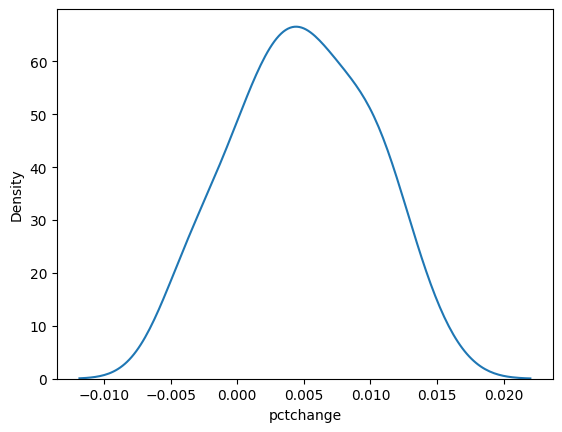

In [95]:
sns_kde_brent = sns.kdeplot(brent_df['pctchange'], label='Brent')
brent_kde_values = sns_kde_brent.get_lines()[0].get_ydata()
brent_x_values = sns_kde_brent.get_lines()[0].get_xdata()

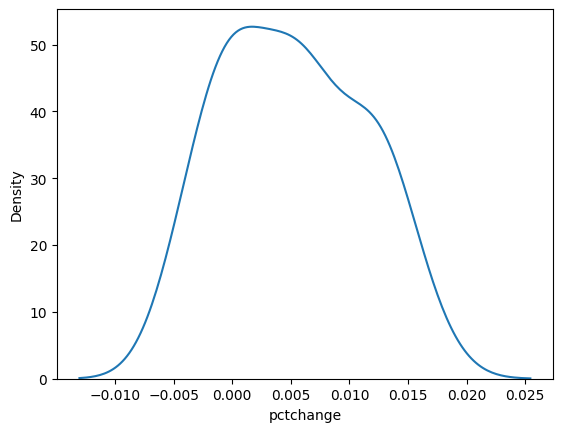

In [96]:
sns_kde_wti = sns.kdeplot(wti_df['pctchange'], label='WTI')
wti_kde_values = sns_kde_wti.get_lines()[0].get_ydata()
wti_x_values = sns_kde_wti.get_lines()[0].get_xdata()

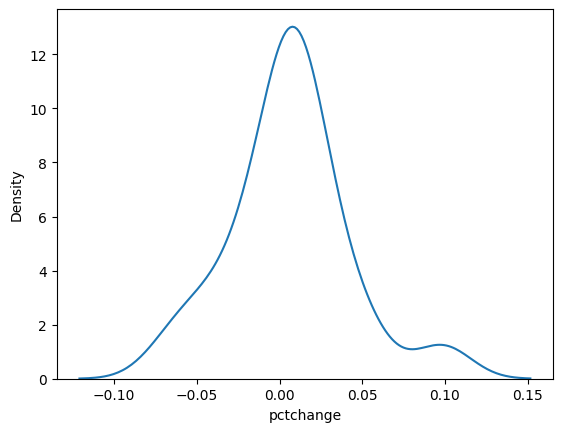

In [97]:
sns_kde_henry = sns.kdeplot(henry_df['pctchange'], label='Henry')
henry_kde_values = sns_kde_henry.get_lines()[0].get_ydata()
henry_x_values = sns_kde_henry.get_lines()[0].get_xdata()

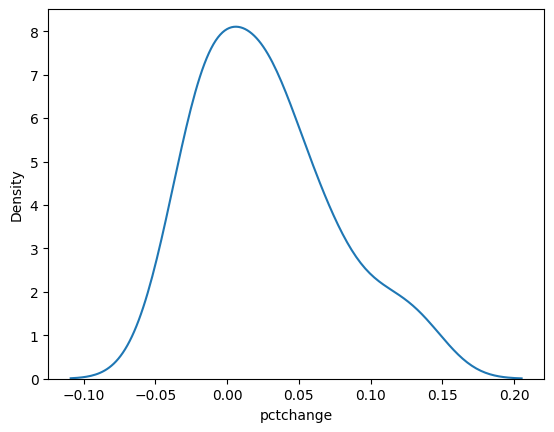

In [98]:
sns_kde_probs = sns.kdeplot(df_probs_grouped['pctchange'], label='Prediction Market')
probs_kde_values = sns_kde_probs.get_lines()[0].get_ydata()
probs_x_values = sns_kde_probs.get_lines()[0].get_xdata()

In [99]:

# Create Plotly figure
fig = plgo.Figure()

# Add KDE line
fig.add_trace(plgo.Scatter(x=brent_x_values, y=brent_kde_values, mode='lines', name='Brent'))
fig.add_trace(plgo.Scatter(x=wti_x_values, y=wti_kde_values, mode='lines', name='WTI'))
fig.add_trace(plgo.Scatter(x=henry_x_values, y=henry_kde_values, mode='lines', name='Henry'))
fig.add_trace(plgo.Scatter(x=probs_x_values, y=probs_kde_values, mode='lines', name='Prediction Market'))

# Update layout
#title='Kernel Density Estimate (KDE) of Commodities and Prediction Market Values',
fig.update_layout(xaxis=dict(title='pct change Value'),
                  yaxis=dict(title='Density'),
                  showlegend=True)

# Show plot
fig.show()

In [100]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y


x_brent, y_brent = ecdf(brent_df['pctchange'])
x_wti, y_wti = ecdf(wti_df['pctchange'])
x_henry, y_henry = ecdf(henry_df['pctchange'])
x_probs, y_probs = ecdf(df_probs_grouped['pctchange'])

fig = plgo.Figure()

# Add KDE line
fig.add_trace(plgo.Scatter(x=x_brent, y=y_brent, mode='lines', name='Brent'))
fig.add_trace(plgo.Scatter(x=x_wti, y=y_wti, mode='lines', name='WTI'))
fig.add_trace(plgo.Scatter(x=x_henry, y=y_henry, mode='lines', name='Henry'))
fig.add_trace(plgo.Scatter(x=x_probs, y=y_probs, mode='lines', name='Prediction Market'))

# Update layout
#title='ECDF of Commodities and Prediction Market Values',
fig.update_layout(xaxis=dict(title='Percent Change Value'),
                  yaxis=dict(title='Density'),
                  showlegend=True)

# Show plot
fig.show()

In [60]:
from scipy.stats import ks_2samp

# Perform KS test
 
print(ks_2samp(brent_df['pctchange'], df_probs_grouped['pctchange']))
print(ks_2samp(wti_df['pctchange'], df_probs_grouped['pctchange']))
print(ks_2samp(henry_df['pctchange'], df_probs_grouped['pctchange']))

KstestResult(statistic=0.5384615384615384, pvalue=1.5620116895752575e-05, statistic_location=0.013302647796109568, statistic_sign=1)
KstestResult(statistic=0.5128205128205128, pvalue=4.9326684933955495e-05, statistic_location=0.014628041432201089, statistic_sign=1)
KstestResult(statistic=0.3076923076923077, pvalue=0.04926851591609082, statistic_location=0.02109034570930124, statistic_sign=1)
